# Basic stats

Using ETISplus database.

Table of contents:

   * [Rail-distances](#Rail-distances-(no-network))
   * [Rail-Undirected](#Rail-Undirected)
   * [Rail-Directed](#Rail-Directed)
   * [Choropleths](#Choropleths)


REFS:

   * http://etisplus.eu, https://ftp.demis.nl
   * [Barthelemy10]
   * [Barthelemy18]

In [1]:
from region_freight import *

#from city_mrio import *
from cfg import *
from tools import convert_ig_to_nx
from measure import basic_stats_ig,plot_local_basic_stats_ig,print_global_basic_stats_ig, link_overlap

import cm_ml.cm as cm_cy
from cm_ml.cmtools import *
from cm_ml.cmtools_spatial import *
from cm_ml.dataset import *
from scitools.tools import logfit

from scipy import stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#%matplotlib notebook  
%matplotlib inline

could not load rpy2


## Rail distances (no network)

In [14]:
plt.rc('font',size=17)
tra_type= 'rail'
year='2010'
data_src='observed'
#data_src='harmonised'
d = load_etisplus(year=year,geodata=True, data_src=data_src, directed=False)
g = d[tra_type]
A = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute=None, default=0, eids=False)
A = np.array(A.data)
if np.any(A>1): 
    warnings.warn('multiple edge')
    A=np.clip(A,0,1)
k=np.array(A.sum(axis=0))

D = get_distance_matrix(d,tra_type='rail')
D_= D+D.transpose()

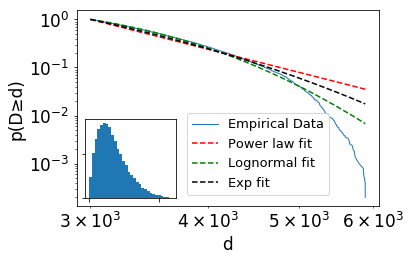

In [30]:
# fit_dij():
n = D_.shape[0]
il = np.tril_indices(n,-1)
dij_low = D_[il]

# powerlawfit
data=dij_low;xmin=3000 # None
fit = powerlaw.Fit(data, discrete=False,xmin=xmin)
fit.distribution_compare('power_law', 'lognormal', 'exponential')
ax=fit.plot_ccdf( linewidth=1, label='Empirical Data')
fit.power_law.plot_ccdf(ax=ax, color='r', linestyle='--', label='Power law fit')
fit.lognormal.plot_ccdf(ax=ax, color='g', linestyle='--', label='Lognormal fit')
fit.exponential.plot_ccdf(ax=ax, color='k', linestyle='--', label='Exp fit')
ax.set_ylabel(u"p(D≥d)")
ax.set_xlabel("d")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='lower center',bbox_to_anchor=(0.6, 0.025),fontsize=13)
#plt.show()

# inset
#https://matplotlib.org/gallery/axes_grid1/inset_locator_demo.html
axins = inset_axes(ax, width="30%", height="40%", loc=3)
axins.hist(dij_low, 30)
#axins.set_ylabel("count")
#xins.set_xlabel("k")
axins.tick_params(labelleft=False, labelbottom=False)
"""
# exponential fit
# [Barthelemy 10] Fig.7
# get histogram: x=bin centers, y=frequencies
hist, bin_edges = np.histogram(dij_low, density=True)
x=(bin_edges[0:-1]+bin_edges[1:])/2.
slope, intercept, r_value, p_value, std_err = logfit(x,hist,ax=None, fun='exp',xlabel='$d_{ij}$',ylabel='freq')
""" 
# save 
fig = plt.gcf()
fig.subplots_adjust(bottom=0.2,left=0.2)
plt.savefig('p_dij.pdf')   

In [7]:
fit.xmin
R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print('fit : powerlaw vs exp:  R={}, p={}'.format(R,p))
R, p = fit.distribution_compare('lognormal', 'exponential', normalized_ratio=True)
print('fit : lognorm vs exp: R={}, p={}'.format(R,p))
R, p = fit.distribution_compare('lognormal', 'power_law', normalized_ratio=True)
print('fit : lognorm vs pow: R={}, p={}'.format(R,p))

fit : powerlaw vs exp:  R=-2.2254336569401114, p=0.026052140204427834
fit : lognorm vs exp: R=0.8940708758544448, p=0.3712839707744726
fit : lognorm vs pow: R=1.1260667091037826, p=0.2601372839806336


In [ ]:
# characteristic length
# cf [BArthelemy10] p.12  ~1000km
print("characteristic length = {}".format(1./np.abs(slope)))


In [20]:
# compare to distUBCM distribution: fit
nbins=20
class_dij,B_d,bin_edges_distUBCM = get_classes(D_,A,bins=nbins)
dij=D; Nd=nbins
pij,z,W = solve_lagrangian_distance(k,D_,class_dij,B_d,Nd,loops=1000,precision=10e-2)

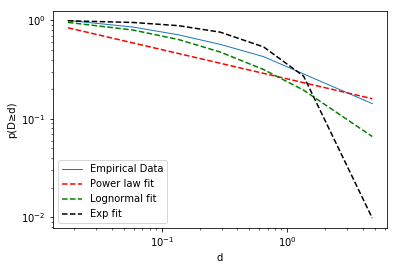

In [22]:
# compare to distUBCM distribution: plot
x=(bin_edges_distUBCM[0:-1]+bin_edges_distUBCM[1:])/2.
Wflat=W.flatten()
idx = Wflat>0
#logfit(x[idx],Wflat[idx],ax=None, fun='exp',xlabel='$d_{ij}$',ylabel='freq')

# powerlawfit
data= Wflat[idx];xmin=0.01
fit = powerlaw.Fit(data, discrete=False,xmin=xmin)
fit.distribution_compare('power_law', 'lognormal', 'exponential')
ax=fit.plot_ccdf( linewidth=1, label='Empirical Data')
fit.power_law.plot_ccdf(ax=ax, color='r', linestyle='--', label='Power law fit')
fit.lognormal.plot_ccdf(ax=ax, color='g', linestyle='--', label='Lognormal fit')
fit.exponential.plot_ccdf(ax=ax, color='k', linestyle='--', label='Exp fit')
ax.set_ylabel(u"p(D≥d)")
ax.set_xlabel("d")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=3)
plt.show()

Comment:
   
   * fit of binned data:
       * exponential law expected.
           * fit not good at extremal values. 
           *  small values: spatial aggregation (only regions are considered) may be the cause.
   * fit of W from distUBCM
       * very good fit
       * but **slope disagrees** with sample fit

## Rail Undirected

In [2]:
#load undirected
tra_type= 'rail'
year='2010'
data_src='observed'
#data_src='harmonised'
d = load_etisplus(year=year,geodata=True, data_src=data_src, directed=False)
D = get_distance_matrix(d,tra_type='rail')
D_= D+D.transpose()

/home/aurelien/local/git/mplex/region_freight.py:137: UserWarning: has loop
  loop=True;  warnings.warn('has loop')
/home/aurelien/local/git/mplex/region_freight.py:139: UserWarning: has multiple
  multiple=True; warnings.warn('has multiple')


In [13]:
print(d['rail'].summary())
print(d['sea'].summary())

IGRAPH UNW- 289 7248 -- 
+ attr: name (v), weight (e)
IGRAPH UNW- 171 2190 -- 
+ attr: name (v), weight (e)


In [3]:
bs = basic_stats_ig(d,directed=False)
#print_global_basic_stats_ig(bs)
pd.DataFrame(bs)


geodata                                               rail  \
NSin_NDin         NaN  [1.8694946117645848e-05, 2.516132210704705e-05...   
NSout_NDout       NaN  [1.8694946117645848e-05, 2.516132210704705e-05...   
between           NaN  [17.774345924773577, 446.24154594816804, 465.7...   
deg               NaN  [48, 100, 102, 60, 77, 85, 121, 145, 107, 42, ...   
deg_avg           NaN                                            50.1592   
dens              NaN                                           0.174164   
evcent            NaN  [0.3977908316860345, 0.6542522854853283, 0.670...   
knn               NaN  [102.25, 77.56, 77.51960784313725, 82.6, 77.90...   
shortest          NaN  [[0, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2,...   
shortest_avg      NaN                                            2.25086   
shortest_max      NaN                                                  5   
stren             NaN  [1150432.0, 3225737.0, 5033637.0, 172388.0, 37...   
stren_avg         NaN                                        4.43606e+06   
trans             NaN  [0.6648936170212766, 0.46444444444444444, 0.46...   
trans_avg         NaN                                            0.67787   

                                                            sea  
NSin_NDin     [0.00014088369086396026, 0.0003440588295365642...  
NSout_NDout   [0.00014088369086396026, 0.0003440588295365642...  
between       [123.07623039650363, 348.3593528387272, 92.057...  
deg           [56, 88, 68, 65, 79, 53, 30, 27, 69, 12, 79, 3...  
deg_avg                                                  25.614  
dens                                                   0.150671  
evcent        [0.7445335733194299, 0.9470175048642753, 0.848...  
knn           [57.267857142857146, 44.51136363636363, 52.705...  
shortest      [[0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1,...  
shortest_avg                                            1.95512  
shortest_max                                                  4  
stren         [11476000.0, 44041000.0, 14307000.0, 7845000.0...  
stren_avg                                            8.5064e+06  
trans         [0.7201298701298702, 0.45428422152560083, 0.62...  
trans_avg                                              0.852936

In [4]:
g = d[tra_type]
A = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute=None, default=0, eids=False)
A = np.array(A.data)
if np.any(A>1): 
    warnings.warn('multiple edge')
    A=np.clip(A,0,1)

W = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute='weight', default=0, eids=False)
W = np.array(W.data)
s = np.array(g.strength(weights="weight"))
k=np.array( A.sum(axis=0))

Calculating best minimal value for power law fit


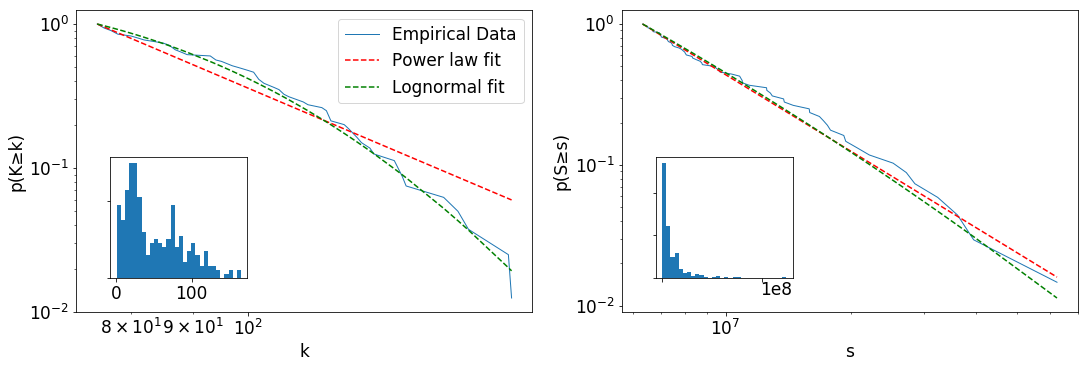

In [8]:
#plots: TAIL : CCDF (k,s,w)
#fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(15,5),constrained_layout=True)
plt.rc('font',size=17)
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5),constrained_layout=True)
#### k
data=k;xmin=75
fit_k = powerlaw.Fit(data, discrete=True,xmin=xmin,xmax=None)
fit_k.distribution_compare('power_law', 'lognormal', 'exponential')
fit_k.plot_ccdf(ax=ax1, linewidth=1, label='Empirical Data')
fit_k.power_law.plot_ccdf(ax=ax1, color='r', linestyle='--', label='Power law fit')
fit_k.lognormal.plot_ccdf(ax=ax1, color='g', linestyle='--', label='Lognormal fit')
#fit_k.exponential.plot_ccdf(ax=ax1, color='k', linestyle='--', label='Exp fit')
ax1.set_ylabel(u"p(K≥k)")
ax1.set_xlabel("k")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=1)

# inset
#https://matplotlib.org/gallery/axes_grid1/inset_locator_demo.html
axins = inset_axes(ax1, width="30%", height="40%", loc=3, borderpad=2)
axins.hist(k, 30)
#axins.set_ylabel("count")
#xins.set_xlabel("k")
axins.tick_params(labelleft=False, labelbottom=True)
#right_inset_ax.set_title('histogram')
#right_inset_ax.set_xticks([])
#right_inset_ax.set_yticks([])

#### s
data=s ; xmin=None; #xmin=1e6
fit_s = powerlaw.Fit(data, discrete=False,xmin=xmin)
fit_s.distribution_compare('power_law', 'lognormal', 'exponential')
fit_s.plot_ccdf(ax=ax2,linewidth=1, label='Empirical Data')
fit_s.power_law.plot_ccdf(ax=ax2, color='r', linestyle='--', label='Power law fit')
fit_s.lognormal.plot_ccdf(ax=ax2, color='g', linestyle='--', label='Lognormal fit')
#fit_s.exponential.plot_ccdf(ax=ax2, color='k', linestyle='--', label='exp fit')
ax2.set_ylabel(u"p(S≥s)")
ax2.set_xlabel("s")
    
# inset
#https://matplotlib.org/gallery/axes_grid1/inset_locator_demo.html
axins2 = inset_axes(ax2, width="30%", height="40%", loc=3,  borderpad=2)
axins2.hist(s, 30)
#axins.set_ylabel("count")
#xins.set_xlabel("k")
axins2.tick_params(labelleft=False, labelbottom=False)    
    


plt.savefig('ccdf_powerlaw_fit.pdf')
plt.show()



Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


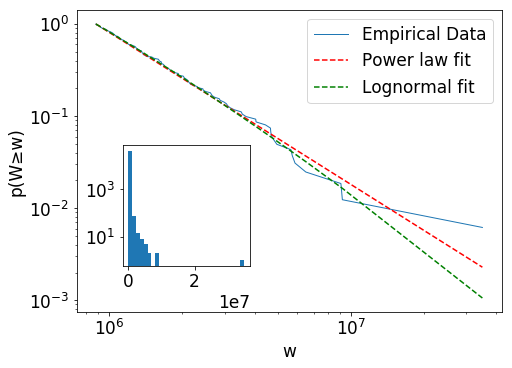

In [37]:
# the same for W only, as it was asked by a reviewer
fig, ax3 = plt.subplots(1, 1,figsize=(7,5),constrained_layout=True)

#### w
il2=np.tril_indices(W.shape[0],-1)
data=W[il2]; xmin=None;#xmin=1e5
fit = powerlaw.Fit(data, discrete=False,xmin=xmin)
fit.distribution_compare('power_law', 'lognormal', 'exponential')
fit.plot_ccdf(ax=ax3,linewidth=1, label='Empirical Data')
fit.power_law.plot_ccdf(ax=ax3, color='r', linestyle='--', label='Power law fit')
fit.lognormal.plot_ccdf(ax=ax3, color='g', linestyle='--', label='Lognormal fit')
##fit.exponential.plot_ccdf(ax=ax3, color='k', linestyle='--', label='exp fit')
ax3.set_ylabel(u"p(W≥w)")
ax3.set_xlabel("w")

axins3 = inset_axes(ax3, width="30%", height="40%", loc=3,  borderpad=2.7)
axins3.hist(data, 30,log=True)

handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, loc=1)
##axins.set_ylabel("count")
##xins.set_xlabel("k")
#axins3.tick_params(labelleft=False, labelbottom=False)    

plt.savefig('ccdf_powerlaw_fit_Wonly.pdf')
plt.show()


In [51]:
# who is the oulier ?
seq=g.es.select(lambda edge: edge['weight'] >2e7)#[0]
[e.index for e in seq]
for e in seq:
    print(g.vs[g.es[e.index].source]['name'])
    print(g.vs[g.es[e.index].target]['name'])

1250007
1290303


In [51]:
print("fit k: EXP lambda={}".format(fit_k.exponential.parameter1))
print("fit k: LN xmin={} xmax={}".format(fit_k.lognormal.xmin,fit_k.lognormal.xmax))
# fit: parameters values
print("fit k: LN mu={} sigma={}".format(fit_k.lognormal.mu,fit_k.lognormal.sigma))
print("fit s: LN mu={} sigma={}".format(fit_s.lognormal.mu,fit_s.lognormal.sigma))
# significance: cf powerlaw.pdf p.8
""" <<R is the loglikelihood ratio between the two candidate distributions. This number will be positive
if the data is more likely in the first distribution, and negative if the data is more likely in the second
distribution. The significance value for that direction is p>>.
""" 
R, p = fit_k.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print('fit k: powerlaw vs exp:  R={}, p={}'.format(R,p))
R, p = fit_k.distribution_compare('lognormal', 'exponential', normalized_ratio=True)
print('fit k: lognorm vs exp: R={}, p={}'.format(R,p))
R, p = fit_k.distribution_compare('lognormal', 'power_law', normalized_ratio=True)
print('fit k: lognorm vs pow: R={}, p={}'.format(R,p))

R, p = fit_s.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print('fit s: powerlaw vs exp:  R={}, p={}'.format(R,p))
R, p = fit_s.distribution_compare('lognormal', 'exponential', normalized_ratio=True)
print('fit s: lognorm vs exp: R={}, p={}'.format(R,p))
R, p = fit_s.distribution_compare('lognormal', 'power_law', normalized_ratio=True)
print('fit s: lognorm vs pow: R={}, p={}'.format(R,p))

fit k: EXP lambda=0.03791821561338294
fit k: LN xmin=75.0 xmax=None
fit k: LN mu=4.3868373591870995 sigma=0.3155186486826067
fit s: LN mu=9.567332917660654 sigma=1.9881413617571273
fit k: powerlaw vs exp:  R=-3.2091982076789223, p=0.0013310569912457345
fit k: lognorm vs exp: R=0.663410090250358, p=0.5070679452868343
fit k: lognorm vs pow: R=1.8978273043258629, p=0.057718835129711425
fit s: powerlaw vs exp:  R=1.4350690715211938, p=0.15126741590120504
fit s: lognorm vs exp: R=1.6121804324338804, p=0.10692268202606807
fit s: lognorm vs pow: R=0.3579994269819367, p=0.7203437423712857


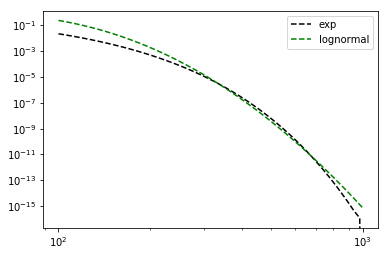

In [50]:
# PLOT CCDF with extended x range
x=np.logspace(2,3,100)
y_exp=fit_k.exponential._cdf_base_function(x)
y_ln=fit_k.lognormal._cdf_base_function(x)
plt.loglog(x,1-y_exp,'k--',label='exp')
plt.loglog(x,1-y_ln,'g--',label='lognormal')
plt.legend()


(1.249102551065232,
 5.6064652861360615,
 0.9412770990228484,
 2.307530558984238e-137,
 0.026447655000397766)

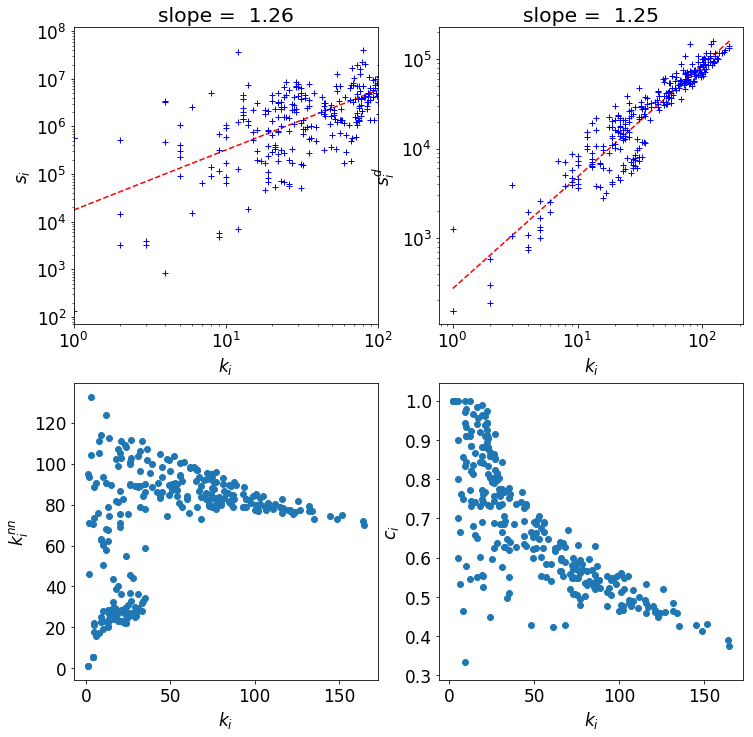

In [9]:
# nonlinear dependence(s=f(k),s^d=f(k)) ; 
# knn_i=f(k_i), clustering_i=f(k_i)
fig,axes=plot_local_basic_stats_ig(bs,tra_type,directed=False)
axes[0][0].set_xlim(1,100) # DOESN'T WORK

# add $s^d=f(k)$
F_i_in,F_i_out = F_i(A,D_)
idx = (F_i_in>0)
logfit(k[idx],F_i_in[idx],ax=axes[0][1], fun='pow',xlabel="$k_i$",ylabel='$s^d_i$') 



r_value_s= 0.6588066858861116
r_value_sd= 0.9412770990228484


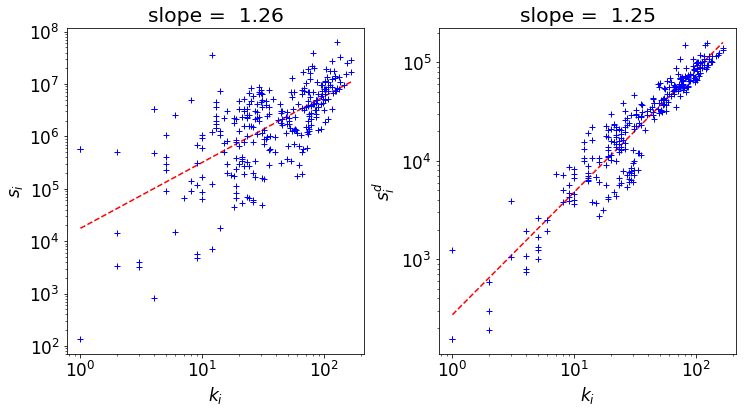

In [55]:
# only s_i and s^d_i vs k_i
#fig, axes = plt.subplots(1, 2,figsize=(12, 9))
fig, axes = plt.subplots(1,2,figsize=(12, 6))    
k=bs[tra_type]['deg']
s=bs[tra_type]['stren']
slope, intercept, r_value_s, p_value, std_err= logfit(k,s,ax=axes[0], fun='pow',xlabel='$k_i$',ylabel='$s_i$')
slope, intercept, r_value_sd, p_value, std_err=logfit(k[idx],F_i_in[idx],ax=axes[1], fun='pow',xlabel="$k_i$",ylabel='$s^d_i$') 
plt.subplots_adjust(wspace=0.25)
print('r_value_s=',r_value_s)
print('r_value_sd=',r_value_sd)
# save 
plt.savefig('basic_stats.pdf')

Comments:
    
   * lognormal fit ok for $k$.
   * outliers for $s$

## Rail Directed

Is the graph symmetric (% of single way link).

In [2]:
#load directed
year='2010'
tra_type='rail'
#data_src='harmonised'
data_src='observed'
d_dir = load_etisplus(year=year,geodata=True, data_src=data_src, directed=True)
print(d_dir['rail'].summary())
print(d_dir['sea'].summary())
D = get_distance_matrix(d_dir,tra_type=tra_type)
D_= D+D.transpose()

g = d_dir[tra_type]
A = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute=None, default=0, eids=False)
A = np.array(A.data)
if np.any(A>1): 
    warnings.warn('multiple edge')
    A=np.clip(A,0,1)  
    
kin  = np.sum(A,axis=0)
kout = np.sum(A,axis=1)    
nin = kin.shape[0]
nout = kout.shape[0]

/home/aurelien/local/git/mplex/region_freight.py:137: UserWarning: has loop
  loop=True;  warnings.warn('has loop')
/home/aurelien/local/git/mplex/region_freight.py:139: UserWarning: has multiple
  multiple=True; warnings.warn('has multiple')


IGRAPH DNW- 289 11080 -- 
+ attr: name (v), weight (e)
IGRAPH DNW- 171 3516 -- 
+ attr: name (v), weight (e)


In [3]:
bs_dir = basic_stats_ig(d_dir,directed=True)
print('asym edge {} %'.format(100*bs_dir['rail']['dyad_census']['asym']/g.ecount()))

#print_global_basic_stats_ig(bs)
pd.DataFrame(bs_dir)

/home/aurelien/local/git/mplex/measure.py:595: RuntimeWarning: invalid value encountered in true_divide
  return wei/(wei_sum*  deg )


asym edge 30.830324909747294 %


geodata                                               rail  \
NSin_NDin          NaN  [2.7042149008689732e-05, 2.1651527793317585e-0...   
NSout_NDout        NaN  [3.335274630277355e-05, 9.27871330975003e-05, ...   
between            NaN  [29.961271720765435, 646.4456132263002, 843.40...   
deg_in             NaN  [38, 91, 88, 46, 44, 60, 79, 108, 76, 36, 63, ...   
deg_in_avg         NaN                                            38.3391   
deg_out            NaN  [23, 33, 47, 22, 69, 54, 95, 119, 92, 30, 75, ...   
deg_out_avg        NaN                                            38.3391   
dens               NaN                                           0.133122   
dyad_census        NaN                                (3832, 3416, 34368)   
evcent             NaN  [0.3635735610386553, 0.6583413782552864, 0.649...   
reciprocity        NaN                                           0.691697   
shortest           NaN  [[0, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,...   
shortest_avg       NaN                                            2.41151   
shortest_max       NaN                                                  6   
stren_in           NaN  [658704.0, 1262977.0, 2814425.0, 98444.0, 1720...   
stren_in_avg       NaN                                        2.21803e+06   
stren_out          NaN  [491728.0, 1962760.0, 2219212.0, 73944.0, 2042...   
stren_out_avg      NaN                                        2.21803e+06   
trans              NaN  [0.4098360655737705, 0.3014686598478888, 0.266...   
trans_avg          NaN                                           0.303359   

                                                             sea  
NSin_NDin      [0.00014182950557068636, 0.0004468768537776881...  
NSout_NDout    [0.00019691098128748888, 0.0003516242939509541...  
between        [251.3108035065556, 783.1433088514979, 204.565...  
deg_in         [46, 82, 61, 61, 67, 45, 26, 19, 63, 7, 76, 24...  
deg_in_avg                                               20.5614  
deg_out        [47, 68, 55, 42, 59, 50, 26, 25, 53, 10, 50, 3...  
deg_out_avg                                              20.5614  
dens                                                    0.120949  
dyad_census                                   (1326, 864, 12345)  
evcent         [0.7260383336466593, 0.9552638075337202, 0.835...  
reciprocity                                             0.754266  
shortest       [[0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1,...  
shortest_avg                                              2.0203  
shortest_max                                                   4  
stren_in       [4745000.0, 26651000.0, 8552000.0, 5597000.0, ...  
stren_in_avg                                          4.2532e+06  
stren_out      [6731000.0, 17390000.0, 5755000.0, 2248000.0, ...  
stren_out_avg                                         4.2532e+06  
trans          [0.2592332865825152, 0.1556152125279642, 0.214...  
trans_avg                                               0.435849

Values less than or equal to 0 in data. Throwing out 0 or negative values


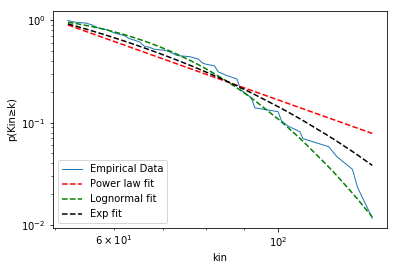

Values less than or equal to 0 in data. Throwing out 0 or negative values


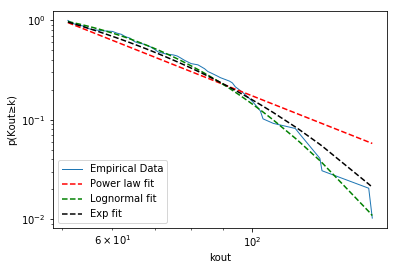

In [5]:
# P(k_in)
data= kin; xmin=50
fit = powerlaw.Fit(data, discrete=True,xmin=xmin)
fit.distribution_compare('power_law', 'lognormal', 'exponential')
ax=fit.plot_ccdf( linewidth=1, label='Empirical Data')
fit.power_law.plot_ccdf(ax=ax, color='r', linestyle='--', label='Power law fit')
fit.lognormal.plot_ccdf(ax=ax, color='g', linestyle='--', label='Lognormal fit')
fit.exponential.plot_ccdf(ax=ax, color='k', linestyle='--', label='Exp fit')
ax.set_ylabel(u"p(Kin≥k)")
ax.set_xlabel("kin")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=3)
plt.show()

# P(k_in)
data= kout; xmin=50
fit = powerlaw.Fit(data, discrete=True,xmin=xmin)
fit.distribution_compare('power_law', 'lognormal', 'exponential')
ax=fit.plot_ccdf( linewidth=1, label='Empirical Data')
fit.power_law.plot_ccdf(ax=ax, color='r', linestyle='--', label='Power law fit')
fit.lognormal.plot_ccdf(ax=ax, color='g', linestyle='--', label='Lognormal fit')
fit.exponential.plot_ccdf(ax=ax, color='k', linestyle='--', label='Exp fit')
ax.set_ylabel(u"p(Kout≥k)")
ax.set_xlabel("kout")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=3)
plt.show()

In [14]:
# fit: parameters values
print("LN mu={} sigma={}".format(fit.lognormal.mu,fit.lognormal.sigma))
# significance: cf powerlaw.pdf p.8
""" <<R is the loglikelihood ratio between the two candidate distributions. This number will be positive
if the data is more likely in the first distribution, and negative if the data is more likely in the second
distribution. The significance value for that direction is p>>.
""" 
R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print('powerlaw vs exp:  R={}, p={}'.format(R,p))
R, p = fit.distribution_compare('lognormal', 'exponential', normalized_ratio=True)
print('lognorm vs exp: R={}, p={}'.format(R,p))

LN mu=4.123252465312944 sigma=0.37982749548161077
R=-4.230877571588332, p=2.327813507175656e-05
R=0.8420208416456691, p=0.3997762875404802


slope=-0.0008415251383339754 intercept=-7.169391674794381


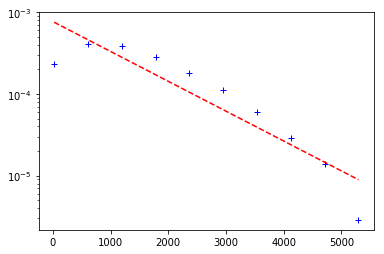

slope=1.23717608735578 intercept=5.602116610182733


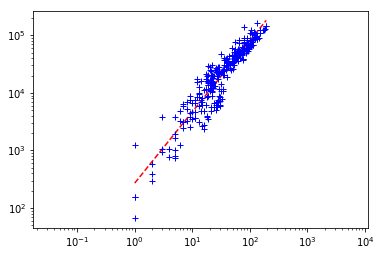

In [7]:
# fit distance strength()
# fit $s^d \propto k^{\Beta}$
# barth spatial10 Fig8
F_i_in,F_i_out = F_i(A,D_)
idx = (F_i_in>0)
logfit(kin[idx],F_i_in[idx],ax=None, fun='pow',xlabel="k_i^{(in)}",ylabel='F_i^{(in)}') 

# Choropleths

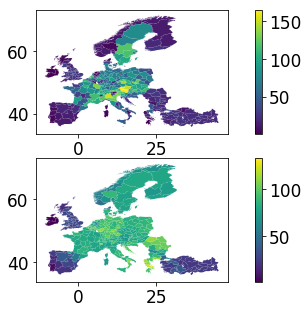

In [52]:
# choropleth plot. see region_freight.py
knn_= knn_avg_UBCM(A,k)

# join geo/rail
df = pd.DataFrame( {'ID': g.vs['name']})
df_merge = pd.merge(df,d['geodata'] ) 

df_EU = df_merge[['ID','geometry']]
gdf_EU = gpd.geodataframe.GeoDataFrame(df_EU)

# look at https://matplotlib.org/tutorials/intermediate/constrainedlayout_guide.html?highlight=make_axes
fig, (ax1,ax2) = plt.subplots(2, 1,figsize=(10,5))
#gdf_EU.plot(k,ax=ax1, legend=True)
#gdf_EU.plot(k,ax=ax1, legend=True, legend_kwds={'shrink':0.5})
#gdf_EU.plot(knn_,ax=ax2, legend=True, legend_kwds={'shrink':0.5})
gdf_EU.plot(k,ax=ax1, legend=True)
gdf_EU.plot(knn_,ax=ax2, legend=True)
#fig.show()
plt.savefig("choropleth.pdf",bbox_inches='tight')


In [12]:
# list highest k_in/k_out 
df_merge['k']=k
df_merge.sort_index(axis=0,by='k').iloc[-20:,:]

""" cf
https://en.wikipedia.org/wiki/Styria  
https://en.wikipedia.org/wiki/Central_Bohemian_Region  

"""


/home/aurelien/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  This is separate from the ipykernel package so we can avoid doing imports until


ID                   Name COUNTRY_ID EZ2006_0_ID EZ2006_1_ID Remark  \
116  1150302           Eszak-Alfold         HU         115       11503          
109  1150201         Kozep-Dunantul         HU         115       11502          
129  1240303           Zuid-Holland         NL         124       12403          
27   1290102    Ostra Mellansverige         SE         129       12901          
141  1060004            Severozapad         CZ         106       10600          
110  1181201               Piemonte         IT         118       11812          
6    1290301    Norra Mellansverige         SE         129       12903          
107  1010303                  Tirol         AT         101       10103          
140  1010201                Karnten         AT         101       10102          
125  1260202                Slaskie         PL         126       12602          
134  1181305         Emilia-Romagna         IT         118       11813          
150  1181303                 Veneto         IT         118       11813          
138  1181304  Friuli-Venezia Giulia         IT         118       11813          
70   1120401               Lorraine         FR         112       11204          
94   1060008        Moravskoslezsko         CZ         106       10600          
7    1060002          Stredni Cechy         CZ         106       10600          
43   1010102       Niederosterreich         AT         101       10101          
101  1181204              Lombardia         IT         118       11812          
28   1010301         Oberosterreich         AT         101       10103          
93   1010202             Steiermark         AT         101       10102          

               Description                           CENTROID  \
116           Eszak-Alfold              POINT (21.2731 47.59)   
109         Kozep-Dunantul            POINT (18.0204 47.2552)   
129           Zuid-Holland             POINT (4.49429 51.986)   
27     Ostra Mellansverige             POINT (16.452 59.1805)   
141            Severozapad            POINT (13.3722 50.4727)   
110               Piemonte             POINT (7.92017 45.262)   
6      Norra Mellansverige            POINT (14.6074 60.5345)   
107                  Tirol            POINT (11.3989 47.2533)   
140                Karnten             POINT (13.861 46.7518)   
125                Slaskie            POINT (19.0046 50.2474)   
134         Emilia-Romagna            POINT (10.9768 44.4399)   
150                 Veneto            POINT (11.8622 45.7378)   
138  Friuli-Venezia Giulia            POINT (13.1198 46.1149)   
70                Lorraine            POINT (6.26425 48.7152)   
94         Moravskoslezsko             POINT (18.003 49.8603)   
7            Stredni Cechy            POINT (15.0165 50.0601)   
43        Niederosterreich            POINT (15.7611 48.2215)   
101              Lombardia  POINT (9.962300000000001 45.6576)   
28          Oberosterreich            POINT (13.8718 48.1171)   
93              Steiermark            POINT (14.8676 47.2201)   

                                              geometry    k  
116  MULTIPOLYGON (((19.66631 47.58853, 19.65102 47...  116  
109  MULTIPOLYGON (((17.07479 47.04874, 17.12630 47...  116  
129  MULTIPOLYGON (((3.83912 51.75827, 3.87590 51.7...  116  
27   MULTIPOLYGON (((14.29599 59.01278, 14.28633 58...  117  
141  MULTIPOLYGON (((12.10020 50.31833, 12.12595 50...  120  
110  MULTIPOLYGON (((6.63000 45.10933, 6.62708 45.1...  121  
6    MULTIPOLYGON (((11.92697 59.79048, 11.93366 59...  121  
107  MULTIPOLYGON (((10.21300 47.15758, 10.22193 47...  123  
140  MULTIPOLYGON (((12.65683 47.09952, 12.69959 47...  124  
125  MULTIPOLYGON (((18.03506 50.06577, 18.04986 50...  126  
134  MULTIPOLYGON (((9.20144 44.68648, 9.19939 44.6...  127  
150  MULTIPOLYGON (((10.84016 45.83277, 10.83248 45...  132  
138  MULTIPOLYGON (((12.73260 46.63500, 12.72743 46...  132  
70   MULTIPOLYGON (((5.39371 49.61733, 5.38166 49.6...  134  
94   MULTIPO

In [ ]:
## Sea